In [1]:
# This project is trying to use DT model to predict the win/loss of the NBA game.
# Hence, I might try RF to improve my model to get a better result.

In [2]:
# The dataset I use in this study is extracted from basketball-reference.com. 
# It's the 2018-2019 NBA regular season all teams' Game data.

In [32]:
# Some imports
import pandas as pd
import numpy as np
from six import StringIO
from sklearn.model_selection import train_test_split
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
from sklearn.ensemble import RandomForestClassifier 

In [18]:
# Read data
df = pd.read_csv('games_18_19.csv')
# Change the dtype
df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['Date', 'Start(ET)', 'Visitor Team', 'Visitor Pts', 'Home Team', 'Home Pts','OT', 'Score Type', 'Notes']
df.head() # View the first 5 rows

,Date,Start(ET),Visitor Team,Visitor Pts,Home Team,Home Pts,OT,Score Type,Notes
0,2018-10-16,8:00p,Philadelphia 76ers,87,Boston Celtics,105,Box Score,NaN,NaN
1,2018-10-16,10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,NaN,NaN
2,2018-10-17,7:00p,Milwaukee Bucks,113,Charlotte Hornets,112,Box Score,NaN,NaN
3,2018-10-17,7:00p,Brooklyn Nets,100,Detroit Pistons,103,Box Score,NaN,NaN
4,2018-10-17,7:00p,Memphis Grizzlies,83,Indiana Pacers,111,Box Score,NaN,NaN


In [19]:
# Create new features
df['Home_Win'] = df['Visitor Pts'] < df['Home Pts']
# keep the column's label
y_true = df['Home_Win'].values
df['Home_Win'].mean()

0.5907012195121951

In [20]:
from collections import defaultdict

won_last = defaultdict(int)
df['HomeLastWin'] = 0
df['VisitorLastWin'] = 0

# datetime disorder df.sort('Date').iterrows()
for index, row in df.iterrows():
    home_team = row['Home Team']
    visitor_team = row['Visitor Team']
    df.at[index, 'HomeLastWin'] = won_last[home_team]
    df.at[index, 'VisitorLastWin'] = won_last[visitor_team]
    won_last[home_team] = int(row['Home_Win'])
    won_last[visitor_team] = 1 - int(row['Home_Win'])

team_prewins = df[['HomeLastWin', 'VisitorLastWin']].values
team_prewins.mean()

0.4992378048780488

In [35]:
# Split and train the dataset
X_train, X_test, y_train, y_test = train_test_split(team_prewins, y_true, random_state=42)
# Use DecisionTree model
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
dtree.score(X_test,y_test)
# The DT Model accuracy is around 56%.

0.5640243902439024

In [41]:
X_train, X_test, y_train, y_test = train_test_split(team_prewins, y_true, random_state=60)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)
# The RF Model accuracy is roughly 59%.

0.5884146341463414

In [21]:
# Use DecisionTree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
dt = DecisionTreeClassifier(random_state=42)
score = cross_val_score(dt, team_prewins, y_true, scoring = 'accuracy')
print('score is:{0:.1f}%'.format(np.mean(score)*100))

score is:59.1%


In [50]:
# Get the last season games dataset
prewin = pd.read_excel('previouswin.xls')
# Add new feature 'ranking level'
df['HomeTeamRanksHigher'] = 0

for index, row in df.iterrows():
    home_team = row['Home Team']
    visitor_team = row['Visitor Team']
    home_rank = prewin[prewin['Team'] == home_team]['Rk'].values[0]
    visitor_rank = prewin[prewin['Team'] == visitor_team]['Rk'].values[0]
    row['HomeTeamRanksHigher'] = int(home_rank > visitor_rank)
    df.at[index, 'HomeTeamRanksHigher'] = int(home_rank < visitor_rank)
prewin.head()

,Rk,Team,Overall,Home,Road,E,W,A,C,SE,...,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
0,1,Houston Rockets,65-17,34-7,31-10,24-6,41-11,6-4,9-1,9-1,...,21-4,5-3,38-8,5-3,12-1,9-5,10-4,12-0,14-1,3-3
1,2,Toronto Raptors,59-23,34-7,25-16,40-12,19-11,12-4,14-4,14-4,...,18-7,5-7,33-5,4-2,9-5,11-3,10-5,9-2,12-4,4-2
2,3,Golden State Warriors,58-24,29-12,29-12,24-6,34-18,9-1,6-4,9-1,...,14-10,5-1,38-13,5-3,11-3,13-2,11-3,8-3,7-7,3-3
3,4,Boston Celtics,55-27,27-14,28-13,33-19,22-8,12-4,10-8,11-7,...,15-8,11-8,25-9,5-2,14-2,11-6,7-5,7-4,9-4,2-4
4,5,Philadelphia 76ers,52-30,30-11,22-19,34-18,18-12,9-7,11-7,14-4,...,22-5,4-7,31-11,3-4,9-5,5-10,7-5,8-3,13-3,7-0


In [24]:
# use the DT model to test it again
dt = DecisionTreeClassifier(random_state=42)
team_homehigher = df[[
    'HomeLastWin', 'VisitorLastWin', 'HomeTeamRanksHigher'
]].values

score = cross_val_score(dt, team_homehigher, y_true, scoring='accuracy')
print('score is:{0:.1f}%'.format(np.mean(score) * 100))

score is:62.2%


In [46]:
# Use the DT model to test it again
X_train, X_test, y_train, y_test = train_test_split(team_homehigher, y_true, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt.score(X_test,y_test)

0.6128048780487805

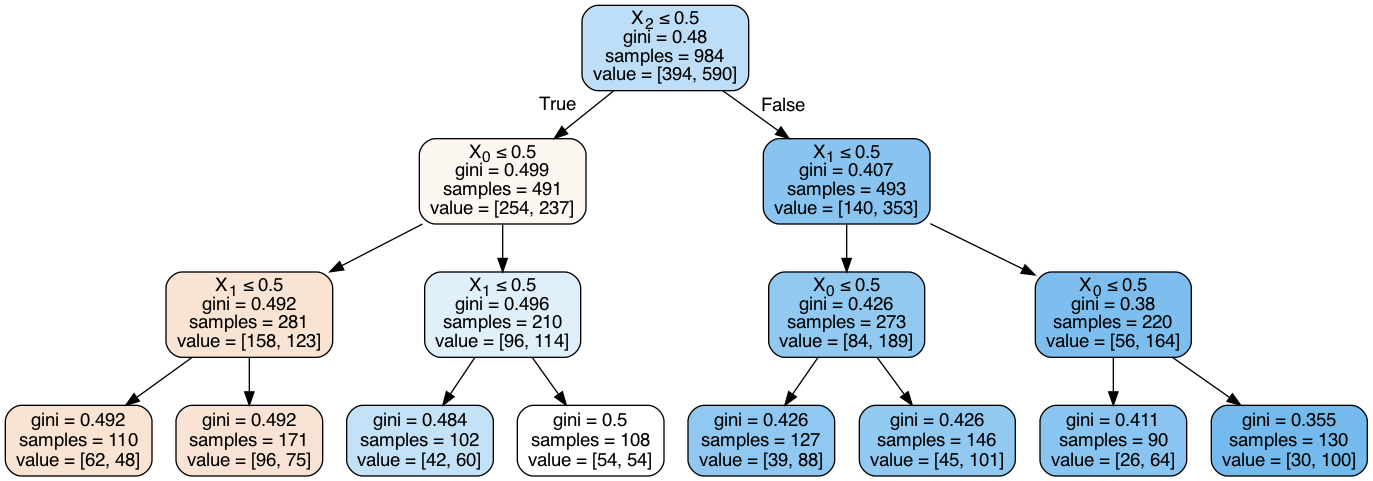

In [47]:
# Plot DT 
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [45]:
# Use the RF model to test it again
X_train, X_test, y_train, y_test = train_test_split(team_homehigher, y_true, random_state=60)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.6280487804878049